In [1]:
!pip install transformers
!pip install pyspark
!pip install sparkdl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=7b64ffe6724735b04458c2b8c77480cbbd68fb794161c5396093569c4a4fa9db
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 3.6 MB/s eta 0:00:00


In [ ]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from pyspark.ml import Pipeline
from pyspark.ml.linalg import VectorUDT, Vectors
from transformers import BertModel
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# إعداد جلسة Spark
spark = SparkSession.builder \
    .appName("Text Classification") \
    .getOrCreate()

# تعيين المسارات للمجلدين
fake_news_folder = "/content/drive/MyDrive/dataset/fake"
real_news_folder = "/content/drive/MyDrive/dataset/real"

# قراءة النصوص الكاذبة
texts = []
labels = []
for filename in os.listdir(fake_news_folder):
    file_path = os.path.join(fake_news_folder, filename)
    with open(file_path, "r", encoding='cp1256') as file:
        text = file.read()
        texts.append(text)
        labels.append(0)

# قراءة النصوص الصادقة
for filename in os.listdir(real_news_folder):
    file_path = os.path.join(real_news_folder, filename)
    with open(file_path, "r", encoding='cp1256') as file:
        text = file.read()
        texts.append(text)
        labels.append(1)



In [ ]:
# تحميل المحددات من النموذج
tokenizer = AutoTokenizer.from_pretrained('aubmindlab/bert-base-arabertv2')

# تحويل النصوص إلى تمثيلات BERT
encoded_texts = []
for news_text in texts:
    inputs = tokenizer.encode_plus(
        news_text,
        None,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    encoded_texts.append(inputs['input_ids'])

# تحويل التمثيلات إلى تنسورفلو
features = tf.concat(encoded_texts, axis=0)

# تحويل التسميات إلى تنسورفلو
labels = tf.convert_to_tensor(labels)

# تحويل الأبعاد
features = tf.reshape(features, (-1, 128))

# تحويل features و labels إلى NumPy arrays
features = features.numpy()
labels = labels.numpy()

# خلط البيانات
from sklearn.utils import shuffle

features, labels = shuffle(features, labels, random_state=42)

# تقسيم البيانات إلى بيانات التدريب والاختبار
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42)

# تحويل البيانات إلى DataFrame في Spark
train_df = spark.createDataFrame(zip(train_features.tolist(), train_labels.tolist()), ["text", "label"])
test_df = spark.createDataFrame(zip(test_features.tolist(), test_labels.tolist()), ["text", "label"])

# تحويل النص إلى نوع Vector
to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())
train_df = train_df.withColumn("text", to_vector("text"))
test_df = test_df.withColumn("text", to_vector("text"))


In [ ]:
# تعديل النموذج إلى Bidirectional GRU
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128), input_shape=(128, 1)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))



# تحويل DataFrame إلى RDD للتدريب مع TensorFlow
train_rdd = train_df.rdd.map(lambda row: (row['text'].toArray(), int(row['label'])))
train_data = train_rdd.map(lambda x: (x[0].tolist(), x[1])).toDF(['text', 'label'])



In [ ]:
# تحويل بيانات التدريب إلى مصفوفات NumPy
train_texts = train_data.select('text').rdd.map(lambda x: x[0]).collect()
train_labels = train_data.select('label').rdd.map(lambda x: x[0]).collect()

# تدريب النموذج
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_texts, train_labels, epochs=100)


Epoch 1/100
51/51 [==============================] - 27s 271ms/step - loss: 0.6798 - accuracy: 0.5591
Epoch 2/100
51/51 [==============================] - 12s 225ms/step - loss: 0.6102 - accuracy: 0.6903
Epoch 3/100
51/51 [==============================] - 12s 227ms/step - loss: 0.5723 - accuracy: 0.7301
Epoch 4/100
51/51 [==============================] - 14s 268ms/step - loss: 0.5010 - accuracy: 0.7655
Epoch 5/100
51/51 [==============================] - 11s 224ms/step - loss: 0.4683 - accuracy: 0.8004
Epoch 6/100
51/51 [==============================] - 13s 265ms/step - loss: 0.4569 - accuracy: 0.8097
Epoch 7/100
51/51 [==============================] - 13s 266ms/step - loss: 0.4295 - accuracy: 0.8128
Epoch 8/100
51/51 [==============================] - 14s 272ms/step - loss: 0.4353 - accuracy: 0.8128
Epoch 9/100
51/51 [==============================] - 14s 271ms/step - loss: 0.4234 - accuracy: 0.8134
Epoch 10/100
51/51 [==============================] - 12s 227ms/step - loss: 0.420

In [ ]:
import numpy as np

# تحويل بيانات الاختبار إلى مصفوفات NumPy
test_texts = np.array(test_df.select('text').collect())
test_labels = np.array(test_df.select('label').collect())

# تحويل البيانات إلى الأبعاد المطلوبة
test_texts = np.squeeze(test_texts, axis=1)
test_labels = np.squeeze(test_labels, axis=1)

# تقييم النموذج على بيانات الاختبار
test_metrics = model.evaluate(test_texts, test_labels)

# طباعة المقاييس
print("Test Data Metrics:")
print("Loss:", test_metrics[0])
print("Accuracy:", test_metrics[1])

from sklearn.metrics import precision_score, recall_score, f1_score

# استخراج التوقعات من النموذج
test_predictions = model.predict(test_texts)
test_predictions = np.round(test_predictions).astype(int)

# حساب المقاييس الإضافية
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

# طباعة المقاييس الإضافية
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


13/13 [==============================] - 2s 38ms/step - loss: 0.3255 - accuracy: 0.8781
Test Data Metrics:
Loss: 0.3254551589488983
Accuracy: 0.8781094551086426
13/13 [==============================] - 2s 70ms/step
Precision: 0.8299595141700404
Recall: 0.9669811320754716
F1 Score: 0.8932461873638344


In [ ]:
model.save("GRU")

In [ ]:
import os
import tensorflow as tf
from transformers import AutoTokenizer
import numpy as np

# تحميل المحددات من النموذج
tokenizer = AutoTokenizer.from_pretrained('aubmindlab/bert-base-arabertv2')

# تحميل النموذج المحفوظ
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/GRU")

# الحصول على النص من المستخدم
user_text = input("أدخل النص الذي ترغب في تصنيفه: ")

# تحويل النص إلى تمثيل BERT
encoded_user_text = tokenizer.encode_plus(
    user_text,
    None,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# تحويل التمثيل إلى تنسورفلو
user_feature = tf.reshape(encoded_user_text['input_ids'], (1, -1))

# التنبؤ باستخدام النموذج المحفوظ
user_prediction = loaded_model.predict(user_feature)
user_prediction = np.round(user_prediction).astype(int)

# طباعة التصنيف
if user_prediction[0] == 0:
    print("النص كاذب")
else:
    print("النص صادق")


أدخل النص الذي ترغب في تصنيفه: انفجار بيروت: صاروخ أم طائرة مسيرة أم رؤوس حربية نووية؟
1/1 [==============================] - 1s 854ms/step
النص صادق


In [ ]:
import os
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# تحميل النموذج المحفوظ
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/GRU')

# تحميل التوكنايزر
tokenizer = BertTokenizer.from_pretrained('aubmindlab/bert-base-arabertv2')

# مجلد الأخبار الصحيحة
real_news_folder = '/content/drive/MyDrive/RealNews'

# مجلد الأخبار الكاذبة
fake_news_folder = '/content/drive/MyDrive/FakeNews'

# قائمة لتخزين التصنيفات الفعلية والمتوقعة
actual_labels = []
predicted_labels = []

# تحميل وتصنيف الأخبار الصحيحة
for filename in os.listdir(real_news_folder):
    filepath = os.path.join(real_news_folder, filename)
    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read()

    # تحويل النص إلى تمثيل BERT
    encoded_text = tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    # تحويل التمثيل إلى تنسورفلو
    feature = tf.reshape(encoded_text['input_ids'], (1, -1))

    # التنبؤ باستخدام النموذج المحفوظ
    prediction = loaded_model.predict(feature)
    prediction = np.round(prediction).astype(int)

    # تخزين التصنيفات الفعلية والمتوقعة
    actual_labels.append(1)  # تصنيف الأخبار الصحيحة بـ 1
    predicted_labels.append(prediction[0][0])

# تحميل وتصنيف الأخبار الكاذبة
for filename in os.listdir(fake_news_folder):
    filepath = os.path.join(fake_news_folder, filename)
    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read()

    # تحويل النص إلى تمثيل BERT
    encoded_text = tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    # تحويل التمثيل إلى تنسورفلو
    feature = tf.reshape(encoded_text['input_ids'], (1, -1))

    # التنبؤ باستخدام النموذج المحفوظ
    prediction = loaded_model.predict(feature)
    prediction = np.round(prediction).astype(int)

    # تخزين التصنيفات الفعلية والمتوقعة
    actual_labels.append(0)  # تصنيف الأخبار الكاذبة بـ 0
    predicted_labels.append(prediction[0][0])

# حساب الدقة العامة (Accuracy)
accuracy = accuracy_score(actual_labels, predicted_labels)

# حساب دقة التصنيف الدقيقة والاستدعاء وقياس F1
precision, recall, f1, _ = precision_recall_fscore_support(actual_labels, predicted_labels)

# طباعة القيم
print("الدقة العامة (Accuracy):")
print(accuracy)
print("دقة التصنيف الدقيقة (Precision):")
print(precision[1])  # دقة تصنيف الأخبار الصحيحة
print("الاستدعاء (Recall):")
print(recall[1])  # استدعاء تصنيف الأخبار الصحيحة
print("قياس F1:")
print(f1[1])  # قياس F1 لتصنيف الأخبار الصحيحة


1/1 [==============================] - 0s 37ms/step
الدقة العامة (Accuracy):
0.8532110091743119
دقة التصنيف الدقيقة (Precision):
0.8823529411764706
الاستدعاء (Recall):
0.9574468085106383
قياس F1:
0.9183673469387754


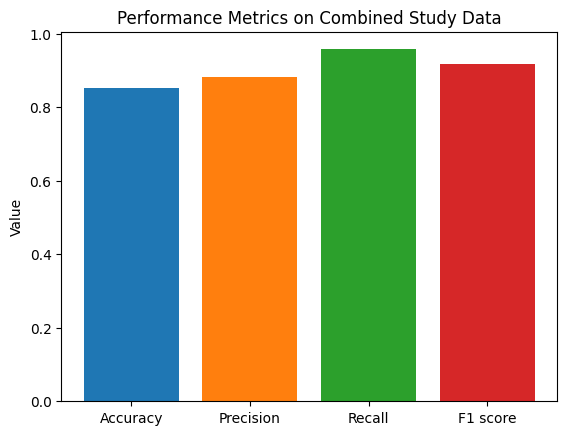

In [ ]:
import matplotlib.pyplot as plt

labels = ['Accuracy', 'Precision', 'Recall', 'F1 score']
values = [accuracy, precision[1], recall[1], f1[1]]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each metric

plt.bar(labels, values, color=colors)
plt.ylabel('Value')
plt.title('Performance Metrics on Combined Study Data')

plt.show()


In [2]:
!pip install kaggle


In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aboislam","key":"2e8ca78959b080da2b71ae60d8cca4a6"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [5]:
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle datasets download -d mohamedabdelaleem007/labeledarticles


 99% 745M/753M [00:11<00:00, 94.6MB/s]
100% 753M/753M [00:12<00:00, 65.6MB/s]


In [7]:
!unzip labeledarticles.zip

Archive:  labeledarticles.zip
  inflating: c5_new_model_weights10064acc.pt  
  inflating: labeled_data.csv        


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# تحميل النموذج المحفوظ
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/GRU')

# تحميل التوكنايزر
tokenizer = BertTokenizer.from_pretrained('aubmindlab/bert-base-arabertv2')

# تحميل ملف البيانات
data = pd.read_csv('/content/labeled_data.csv')

# اختيار عينة عشوائية بنسبة 5 بالمئة
sampled_data = data.sample(frac=0.05, random_state=42)

# قائمة لتخزين التصنيفات الفعلية والمتوقعة
actual_labels = []
predicted_labels = []

# تحميل وتصنيف الأخبار
for index, row in sampled_data.iterrows():
    text = row['text']
    label = row['label']

    # تحويل النص إلى تمثيل BERT
    encoded_text = tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    # تحويل التمثيل إلى تنسورفلو
    feature = tf.reshape(encoded_text['input_ids'], (1, -1))

    # التنبؤ باستخدام النموذج المحفوظ
    prediction = loaded_model.predict(feature)
    prediction = np.round(prediction).astype(int)

    # تخزين التصنيفات الفعلية والمتوقعة
    if label == "credible":
        actual_labels.append(1)  # تصنيف الأخبار الصحيحة بـ 1
    elif label == "not credible":
        actual_labels.append(0)  # تصنيف الأخبار الكاذبة بـ 0

    predicted_labels.append(prediction[0][0])

# حساب الدقة العامة (Accuracy)
accuracy = accuracy_score(actual_labels, predicted_labels)

# حساب دقة التصنيف الدقيقة والاستدعاء وقياس F1
precision, recall, f1, _ = precision_recall_fscore_support(actual_labels, predicted_labels)

# طباعة القيم
print("الدقة العامة (Accuracy):")
print(accuracy)
print("دقة التصنيف الدقيقة (Precision):")
print(precision[1])  # دقة تصنيف الأخبار الصحيحة
print("الاستدعاء (Recall):")
print(recall[1])  # استدعاء تصنيف الأخبار الصحيحة
print("قياس F1:")
print(f1[1])  # قياس F1 لتصنيف الأخبار الصحيحة


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 40ms/step
الدقة العامة (Accuracy):
0.46489026539221445
دقة التصنيف الدقيقة (Precision):
0.5204810669206954
الاستدعاء (Recall):
0.42170767004341536
قياس F1:
0.46591696423812823


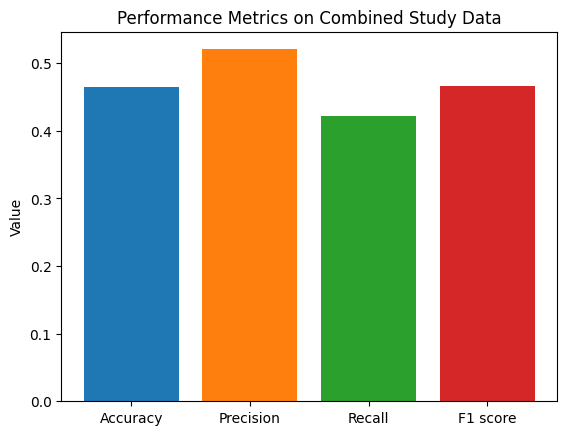

In [ ]:
import matplotlib.pyplot as plt

labels = ['Accuracy', 'Precision', 'Recall', 'F1 score']
values = [accuracy, precision[1], recall[1], f1[1]]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each metric

plt.bar(labels, values, color=colors)
plt.ylabel('Value')
plt.title('Performance Metrics on Combined Study Data')

plt.show()
